In [126]:
df = pd.read_csv("Cloud_stress_test.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Label              863 non-null    object 
 1   MetadataNoToken    863 non-null    float64
 2   NetworkPacketsOut  863 non-null    float64
 3   CPUCreditUsage     863 non-null    float64
 4   CPUUtilization     863 non-null    float64
 5   NetworkOut         863 non-null    float64
 6   NetworkPacketsIn   863 non-null    float64
 7   NetworkIn          863 non-null    float64
dtypes: float64(7), object(1)
memory usage: 54.1+ KB


In [127]:
import os
import pandas as pd
import requests


# 날짜데이터를 Datetime 형식으로 바꿔준다
df.loc[:,'Label'] = pd.to_datetime(df.Label)

# 데이터의 정합성을 확인한다
df.isna().sum()

print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 863
삭제 후 데이터 길이(일자수): 863


Label                0
MetadataNoToken      0
NetworkPacketsOut    0
CPUCreditUsage       0
CPUUtilization       0
NetworkOut           0
NetworkPacketsIn     0
NetworkIn            0
dtype: int64

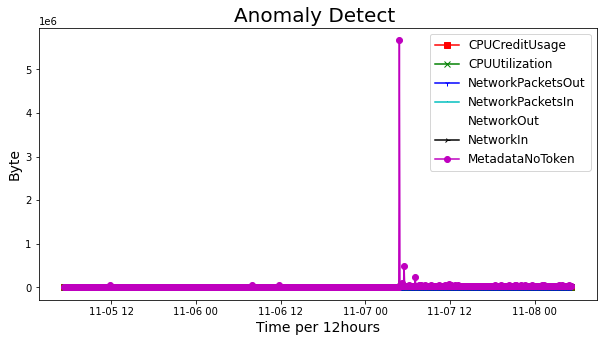

In [137]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (10,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Label, df.CPUCreditUsage, marker='s', color='r')
plt.plot(df.Label, df.MetadataNoToken, marker='x', color='g')
plt.plot(df.Label, df.CPUUtilization , marker='1', color='b')
plt.plot(df.Label, df.NetworkPacketsOut , marker=',', color='c')
plt.plot(df.Label, df.NetworkPacketsIn , marker='_', color='w')
plt.plot(df.Label, df.NetworkOut , marker='4', color='k')
plt.plot(df.Label, df.NetworkIn , marker='o', color='m')


plt.title('Anomaly Detect ', fontsize=20) 
plt.ylabel('Byte', fontsize=14)
plt.xlabel('Time per 12hours', fontsize=14)
plt.legend(['CPUCreditUsage', 'CPUUtilization', 'NetworkPacketsOut', 'NetworkPacketsIn', 'NetworkOut','NetworkIn','MetadataNoToken'], fontsize=12, loc='best')
plt.show()

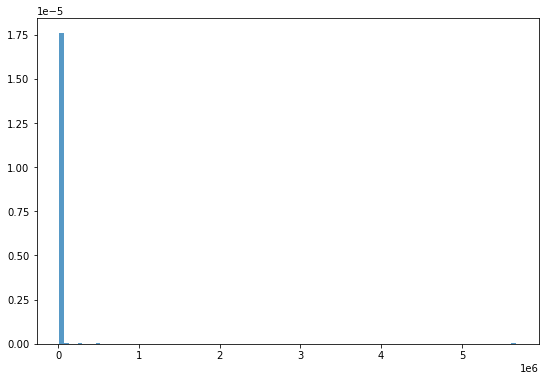

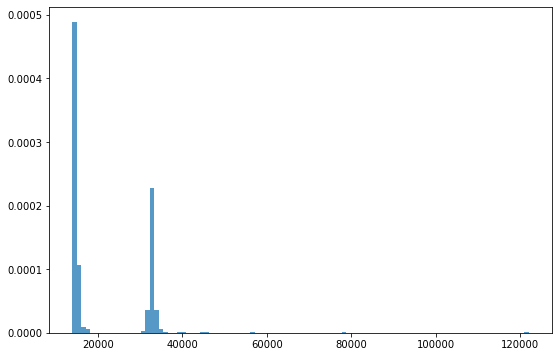

In [139]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.NetworkIn, 100, density=True, alpha=0.75)
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.NetworkOut, 100, density=True, alpha=0.75)

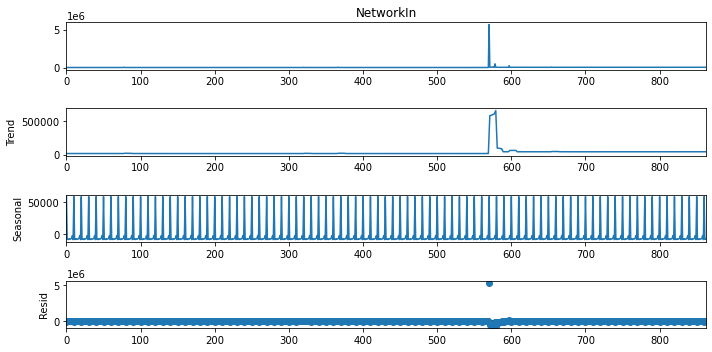

In [140]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 계절적 성분 50일로 가정
# extrapolate_trend='freq' : Trend 성분을 만들기 위한 rolling window 때문에 필연적으로 trend, resid에는 Nan 값이 발생하기 때문에, 이 NaN값을 채워주는 옵션이다.
result = seasonal_decompose(df.NetworkIn, model='additive', two_sided=False, 
                            period=10, extrapolate_trend='freq') 
result.plot()
plt.show()

<AxesSubplot:>

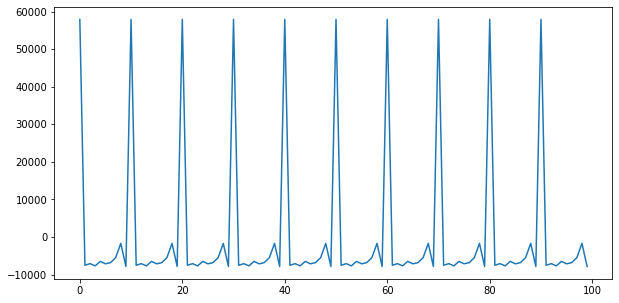

In [141]:
# seasonal 성분은 너무 빼곡하게 보여 다시 확인.
result.seasonal[:100].plot()
# -8 ~ 10 사이를 주기적으로 반복하는게 보인다.

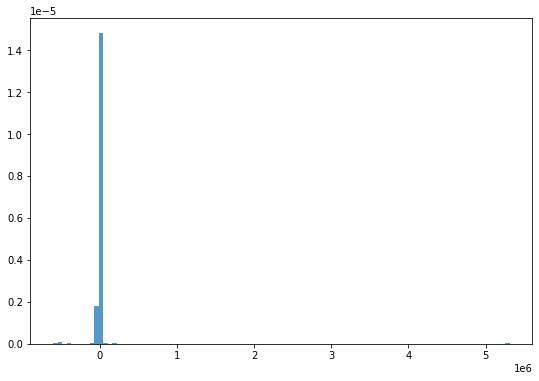

In [142]:
# Residual의 분포 확인
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [143]:
# 데이터 전처리
def my_decompose(df, features, freq=5):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose를 수행한다.
    for f in features:
        result = seasonal_decompose(df[f], model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['CPUCreditUsage', 'CPUUtilization', 'NetworkPacketsOut', 'NetworkPacketsIn', 'NetworkOut','NetworkIn','MetadataNoToken'])
tdf.describe()

,CPUCreditUsage,CPUUtilization,NetworkPacketsOut,NetworkPacketsIn,NetworkOut,NetworkIn,MetadataNoToken
count,863.000000,863.000000,863.000000,863.000000,863.000000,8.630000e+02,863.000000
mean,0.096500,2.176541,184.532185,180.752869,21204.371785,3.362612e+04,12.079772
std,0.517915,11.361565,50.572931,76.383852,8885.836322,8.741920e+04,0.122316
min,0.014327,0.279928,150.040000,140.120000,14491.280000,1.670640e+04,11.520000
25%,0.015050,0.300141,153.040000,143.160000,14738.380000,1.700300e+04,12.000000
50%,0.015527,0.312955,154.840000,145.000000,14934.800000,1.725156e+04,12.000000
75%,0.017803,0.353495,234.800000,234.280000,32695.100000,4.325230e+04,12.120000
max,4.999593,99.708287,643.840000,1038.400000,55256.040000,1.173814e+06,12.600000


In [144]:
rdf.describe()

,CPUCreditUsage,CPUUtilization,NetworkPacketsOut,NetworkPacketsIn,NetworkOut,NetworkIn,MetadataNoToken
count,863.000000,863.000000,863.000000,863.000000,863.000000,8.630000e+02,863.000000
mean,0.005317,-0.101555,-0.004240,-0.008339,-0.416426,-1.416372e+01,0.000150
std,0.249874,5.420108,59.418826,120.136833,3516.424094,1.720492e+05,0.246547
min,-2.403175,-96.780985,-412.399559,-805.149457,-23586.646887,-1.126993e+06,-1.902931
25%,-0.004169,-0.210753,-2.519696,-0.872570,-364.533750,4.059240e+03,-0.113571
50%,-0.000154,-0.108819,1.113202,3.513754,48.544860,6.235657e+03,-0.012157
75%,0.001264,0.360772,3.284607,5.523660,296.613113,7.086876e+03,0.020383
max,3.282349,39.439335,1532.960166,3111.714609,77744.216741,4.485034e+06,2.387843


In [145]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
# [-0.40184982  -0.38035856  -0.39874878  -0.37402025 -195.40645742]

norm_rdf = scaler.transform(rdf)
norm_rdf

[ 5.31700920e-03 -1.01554897e-01 -4.24008091e-03 -8.33908039e-03
 -4.16426366e-01 -1.41637156e+01  1.50358151e-04]


array([[-2.99531066e-02, -6.38602448e-03, -2.10794106e-01, ...,
        -3.16250031e-01, -1.51033491e-01, -1.14918837e+00],
       [-9.75965210e-02,  8.54040120e-02,  1.61027525e-02, ...,
        -2.19497925e-02,  4.08379927e-02, -1.00275157e+00],
       [-2.06522367e-02,  1.05821983e-01,  2.60079821e-01, ...,
         4.05444782e-01,  4.54364949e-02, -1.10336990e+00],
       ...,
       [ 2.21553139e+00,  7.29945221e+00, -2.20859281e-01, ...,
        -4.59644089e-01, -1.54867284e-01, -5.36952795e-01],
       [ 1.31223388e+01, -5.16340981e+00,  3.87413777e-02, ...,
         9.76102585e-02,  3.82065062e-02, -2.41022849e-02],
       [ 1.20666547e+01, -1.78475214e+01,  7.66998998e-02, ...,
         1.58707446e-01,  4.17077247e-02,  2.28247834e+00]])

In [112]:
print(os.getenv('my'))
os.environ['my'] = 'lll'
print(os.getenv('my'))

lll
lll


In [147]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler


# 모델 재현성을 위해 난수 시드설정
tf.random.set_seed(777)
np.random.seed(777)

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['CPUCreditUsage', 'CPUUtilization', 'NetworkPacketsOut', 'NetworkPacketsIn', 'NetworkOut','NetworkIn','MetadataNoToken']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리 - 표준정규분포화
scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

# keras TimeseriesGenerator를 이용해 데이터셋 만들기
train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)  # (32, 10, 5)
print(train_gen[0][1].shape)  # (32, 5)


# 모델만들기
# 2개 층의 LSTM으로 인코더 만듬
# RepeatVector는 input을 window_size만큼 복사해줌
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])


# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
checkpoint_path = os.getenv('dev','./KYW/mynewmodel.ckpt')
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])


hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])
          

model.load_weights(checkpoint_path)

(32, 10, 7)
(32, 7)
Epoch 1/50
23/27 [========================>.....] - ETA: 0s - loss: 0.3684 - mae: 0.3684
Epoch 1: val_loss improved from inf to 0.57644, saving model to ./KYW\mynewmodel.ckpt
27/27 [==============================] - 7s 43ms/step - loss: 0.3636 - mae: 0.3636 - val_loss: 0.5764 - val_mae: 0.5764
Epoch 2/50
26/27 [===========================>..] - ETA: 0s - loss: 0.2471 - mae: 0.2471
Epoch 2: val_loss improved from 0.57644 to 0.38753, saving model to ./KYW\mynewmodel.ckpt
27/27 [==============================] - 0s 16ms/step - loss: 0.5021 - mae: 0.5021 - val_loss: 0.3875 - val_mae: 0.3875
Epoch 3/50
26/27 [===========================>..] - ETA: 0s - loss: 0.3674 - mae: 0.3674
Epoch 3: val_loss did not improve from 0.38753
27/27 [==============================] - 0s 14ms/step - loss: 0.3568 - mae: 0.3568 - val_loss: 0.5774 - val_mae: 0.5774
Epoch 4/50
25/27 [==========================>...] - ETA: 0s - loss: 0.3008 - mae: 0.3008
Epoch 4: val_loss did not improve from 0.

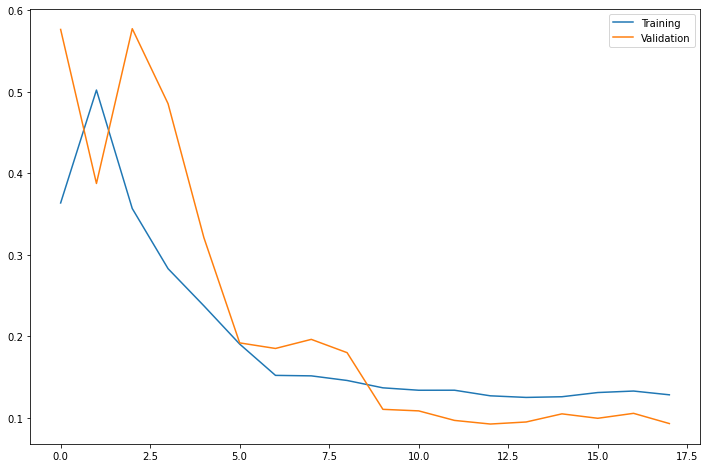

In [148]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

27/27 [==============================] - 1s 4ms/step


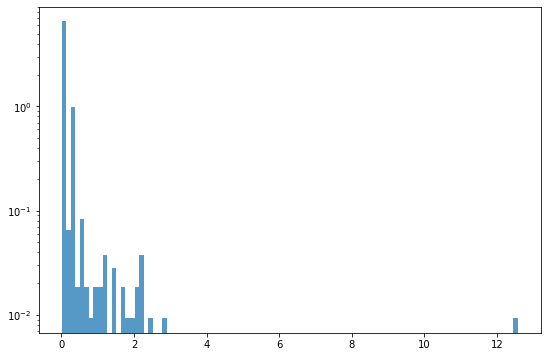

In [149]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [150]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss
threshold = 3
test_df.loc[test_df.Loss>threshold]

,Label,MetadataNoToken,NetworkPacketsOut,CPUCreditUsage,CPUUtilization,NetworkOut,NetworkPacketsIn,NetworkIn,Loss
560,2022-11-07 04:50:00,12.0,2125.8,0.015308,4.202843,122073.0,4106.8,5668562.4,12.586045


In [151]:
threshold = 0.3
test_df.loc[test_df.Loss>threshold]

,Label,MetadataNoToken,NetworkPacketsOut,CPUCreditUsage,CPUUtilization,NetworkOut,NetworkPacketsIn,NetworkIn,Loss
1,2022-11-05 06:15:00,12.6,153.0,0.014495,0.299581,14677.8,142.4,16879.6,0.302138
4,2022-11-05 06:30:00,12.6,151.8,0.014826,0.300000,14642.8,140.6,16776.8,0.307115
9,2022-11-05 06:55:00,12.6,155.4,0.014629,0.332277,14945.2,144.2,17165.2,0.305139
16,2022-11-05 07:30:00,12.6,152.0,0.014518,0.266704,14624.4,142.6,16899.6,0.305260
18,2022-11-05 07:40:00,12.6,151.6,0.014599,0.301789,14594.0,142.0,16850.4,0.306577
...,...,...,...,...,...,...,...,...,...
848,2022-11-08 04:50:00,12.0,241.2,0.016580,44.733370,33907.0,240.8,45828.0,0.514133
849,2022-11-08 04:55:00,12.0,234.4,0.017860,99.672131,32653.8,233.6,42871.8,1.072386
850,2022-11-08 05:00:00,12.0,232.0,3.209380,99.611317,32001.4,231.4,42515.6,1.742040
851,2022-11-08 05:05:00,12.0,235.0,4.992692,55.927758,32923.0,232.4,42751.0,1.698588


C:\Users\nsa01\anaconda3\lib\site-packages\matplotlib\lines.py:189: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


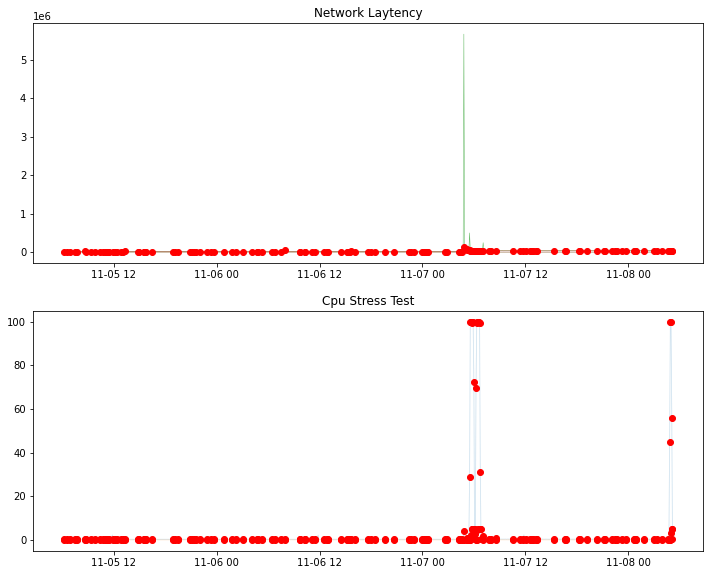

In [160]:
fig = plt.figure(figsize=(12,15))

# 네트워크에 관한 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Network Laytency')
plt.plot(test_df.Label, test_df.NetworkPacketsIn, linewidth=0.5, alpha=0.75, label='NetPacketIn')
plt.plot(test_df.Label, test_df.NetworkPacketsOut, linewidth=0.5, alpha=0.75, label='NetPacketOut')
plt.plot(test_df.Label, test_df.NetworkIn, linewidth=0.5, alpha=0.75, label='NetIn')
plt.plot(test_df.Label, test_df.NetworkOut, linewidth=0.5, alpha=0.75, label='NetOut')
plt.plot(test_df.Label, test_df.NetworkOut, 'or', markevery=[mae_loss>threshold])

# cpu에 관한 그래프입니다.
ax = fig.add_subplot(312)
ax.set_title('Cpu Stress Test')
plt.plot(test_df.Label, test_df.CPUUtilization, linewidth=0.8, alpha=0.21, label='Util')
plt.plot(test_df.Label, test_df.CPUCreditUsage, linewidth=0.8, alpha=0.21, label='Util')
plt.plot(test_df.Label, test_df.CPUUtilization, 'or', markevery=[mae_loss>threshold])
plt.plot(test_df.Label, test_df.CPUCreditUsage, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
#ax = fig.add_subplot(313)
#ax.set_title('Loss')
#plt.plot(test_df.Label, test_df.CPUCreditUsage, linewidth=0.5, alpha=0.75, label='Loss')
#plt.plot(test_df.Label, test_df.CPUCreditUsage, 'or', markevery=[mae_loss>threshold])